In [9]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
from utils import *
from PIL import Image
from PIL.ImageOps import invert

In [11]:
target = "/home/mlfavorfit/Downloads/sample/composition/5_re.jpg"

In [12]:
init_image = center_crop_and_resize(Image.open(target).convert("RGB"))

init_image = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_outpaint/images/nike_1511_white.jpg").convert("RGB") # temp

mask = remove_bg.inference(init_image, rmbg_model).convert("L")
inverted_mask = invert(mask)

object_image = make_outpaint_condition(init_image, mask.convert("RGB"))

In [13]:
caption = clip_image_to_text.inference(object_image, clip_model, mode="simple")
caption

'pair of white orange sneakers'

In [23]:
import torch
import os
import random
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import DDPMScheduler, UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_inpainting_split import KandinskyV22ControlnetInpaintPipeline

In [24]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet-split"
priot_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

In [25]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    priot_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()
# controlnet = ControlNetModel.from_config(os.path.join(decoder_model_path, "controlnet/config.json"))
controlnet = ControlNetModel.from_pretrained(decoder_model_path, subfolder="controlnet")

The config attributes {'center_input_sample': False, 'out_channels': 8} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [26]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        priot_model_path,
        image_encoder=image_encoder,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )

pipeline = KandinskyV22ControlnetInpaintPipeline.from_pretrained(
        decoder_model_path,
        unet=unet,
        movq=movq,
        controlnet=controlnet,
        torch_dtype=torch.float16,
    )

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]
The config attributes {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} were passed to KandinskyV22ControlnetInpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} are not expected by KandinskyV22ControlnetInpaintPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 2966.97it/s]


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


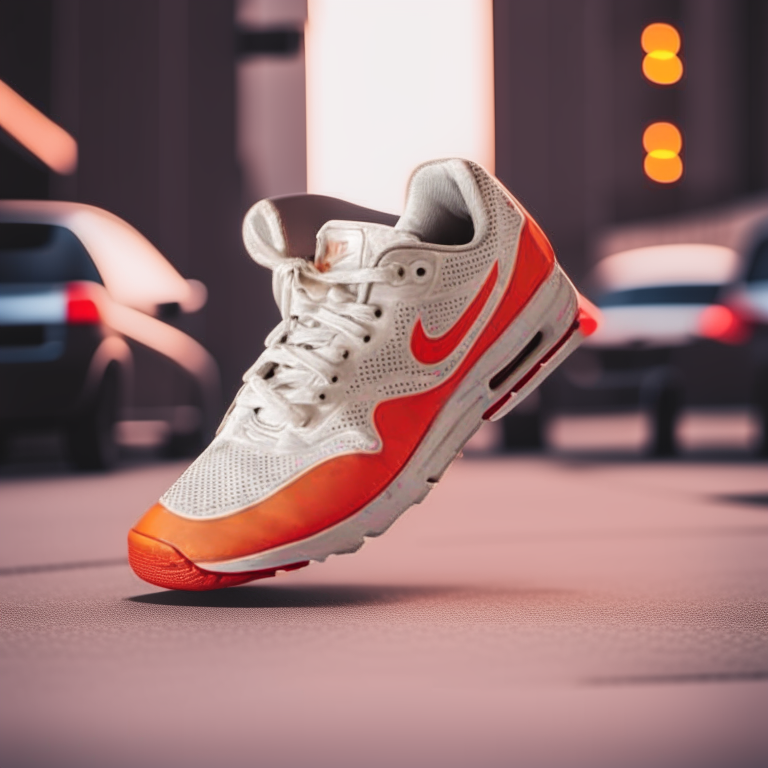

In [41]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

prompt = f"{caption}, street, product photo, professional photography"
negative_prior_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

generator = torch.Generator(device="cuda").manual_seed(8000)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
    )

    output_image = pipeline(image=init_image,
                            mask_image=inverted_mask,
                            control_image=object_image,
                            **prior_output,
                            height=768,
                            width=768,
                            num_inference_steps=50,
                            strength=1.0,
                            guidance_scale=4.0,
                            controlnet_scale=0.5,
                            generator=generator).images[0]

output_image

In [14]:
import argparse
import os
from PIL import Image
from PIL.ImageOps import invert

import accelerate
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from tqdm import tqdm
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from transformers.utils import ContextManagers

from diffusers import DDPMScheduler, UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_inpainting import KandinskyV22InpaintPipeline
from diffusers.training_utils import compute_snr

In [15]:
priot_model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"
decoder_model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet"

In [16]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    priot_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()

In [17]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        priot_model_path,
        image_encoder=image_encoder,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )

pipeline = KandinskyV22ControlnetInpaintPipeline.from_pretrained(
        decoder_model_path,
        unet=unet,
        movq=movq,
        torch_dtype=torch.float16,
    )

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]
The config attributes {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} were passed to KandinskyV22ControlnetInpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} are not expected by KandinskyV22ControlnetInpaintPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 3268.29it/s]


In [20]:
from torchvision import transforms
image_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
        ]
    )

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


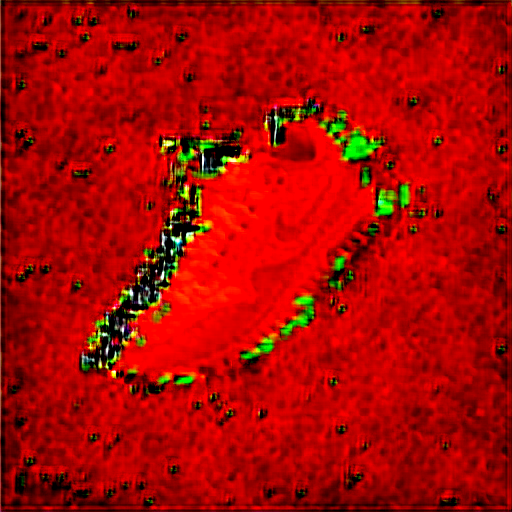

In [23]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

prompt = f"a shoe, street, product photo, professional photography"
negative_prior_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

generator = torch.Generator(device="cuda").manual_seed(8000)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
    )

    output_image = pipeline(image=init_image,
                            mask_image=inverted_mask,
                            hint=image_transforms(object_image).unsqueeze(0),
                            **prior_output,
                            height=512,
                            width=512,
                            num_inference_steps=50,
                            strength=1.0,
                            guidance_scale=4.0,
                            controlnet_scale=1.0,
                            generator=generator).images[0]

output_image